In [106]:
import json
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import torch
import numpy as np
import detectron2
import pandas as pd

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg, instantiate
from detectron2.data import MetadataCatalog
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.utils.visualizer import Visualizer

from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [3]:
f = open('bboxes.json')
data = json.load(f)

In [3]:
for file_name in data:
    img = cv2.imread(f'frames/{file_name}.jpeg')
    for player in data[file_name]:
        x, y, w, h = data[file_name][player]['box']
        x, y, w, h = int(x*img.shape[1]), int(y*img.shape[0]), int(w*img.shape[1]), int(h*img.shape[0])
        if x < 0 : x=0
        if y < 0 : y=0
#         cv2.imwrite(f'all_bboxes/bbox_{player}_{file_name}.png', img[y:y+h,x:x+w])
#         plt.imshow(img[y:y+h,x:x+w,::-1])
#         team = data[file_name][player]['team']
#         plt.title(team)
#         plt.show()
#         break
#     break

In [8]:
 class SegmentatorNewBaseline:
    def __init__(self, model_name, threshold=0.5):
        print ('Using model', model_name)
        
        # Get model config and weights (download if it doesn't exist):
        self.cfg = model_zoo.get_config(model_name, trained=True)
        # self.cfg = LazyConfig.load("/home/darkalert/builds/detectron2/configs/new_baselines/mask_rcnn_R_101_FPN_400ep_LSJ.py")
        self.cfg['model']['roi_heads']['box_predictor']['test_score_thresh'] = threshold
        
        # Init:
        self.model = instantiate(self.cfg.model)
        
        # Load a checkpoint:
        DetectionCheckpointer(self.model).load(self.cfg.train.init_checkpoint)
        
        self.model.eval()
        self.model.to('cuda')

    def __call__(self, img, viz=False):
        # Preprocess input image:
        img_tensor = torch.from_numpy(img)
        img_tensor = torch.permute(img_tensor, (2, 0, 1))
        batch = [{"image": img_tensor.to('cuda')}]
        
        # Inference:
        with torch.no_grad():
            outputs = self.model(batch)[0]

        # Vizualize:
        if viz:
            v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(self.cfg['dataloader']['train']['dataset']['names']), scale=3)
            img = v.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()
            plt.imshow(img)
            plt.show()

        return outputs

In [9]:
def show(img, title='', bgr2rgb=True):
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    if bgr2rgb and img.ndim == 3:
        plt.imshow(img[...,::-1])
    else:
        plt.imshow(img)
    plt.show()

In [18]:
segmentator = SegmentatorNewBaseline('new_baselines/mask_rcnn_R_101_FPN_400ep_LSJ.py', 0.8)

Using model new_baselines/mask_rcnn_R_101_FPN_400ep_LSJ.py


2


/home/yaroslav/anaconda3/envs/cv-env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/yaroslav/anaconda3/envs/cv-env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


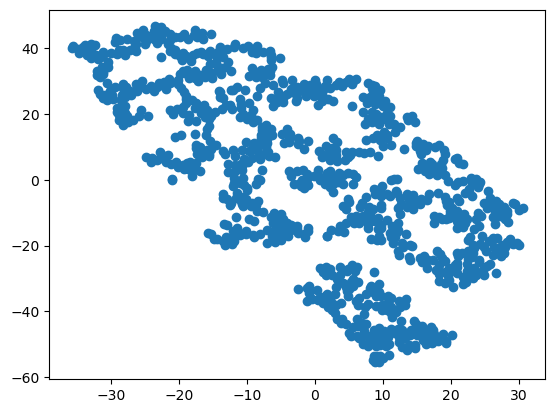

3


/home/yaroslav/anaconda3/envs/cv-env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/yaroslav/anaconda3/envs/cv-env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


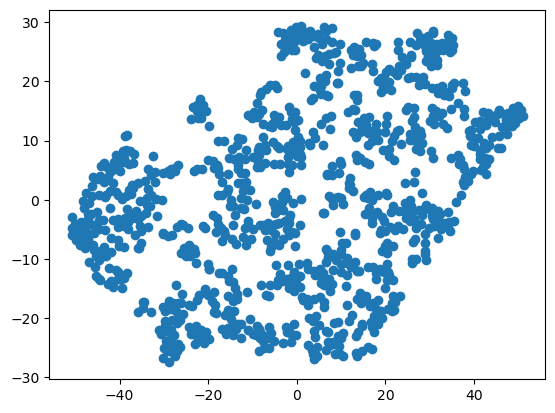

4


/home/yaroslav/anaconda3/envs/cv-env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/yaroslav/anaconda3/envs/cv-env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


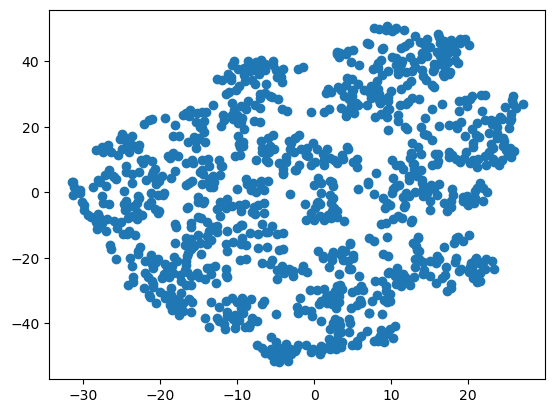

5


/home/yaroslav/anaconda3/envs/cv-env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/yaroslav/anaconda3/envs/cv-env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


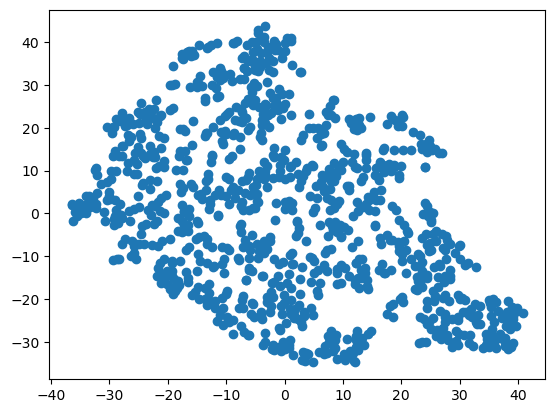

In [177]:
for n in range(2, 6):
    print(n)
    features = []
    for filename in os.listdir('all_bboxes'):
        f = os.path.join('all_bboxes', filename)
        img = cv2.imread(f, 1)
        outputs = segmentator(img, viz=False)
        
        mask = np.zeros(img.shape[:2], dtype=np.uint8)

        for m, l in zip(outputs["instances"].pred_masks,outputs["instances"].pred_classes):
            if l.item() == 0:
                mask += m.cpu().numpy()

        color = ('b','g','r')
        hists_by_channels = []
        for i,col in enumerate(color):
            histr = cv2.calcHist([img],[i],None,[n],[0,256])
            hists_by_channels.append(histr/img.size)

        features.append(np.array(hists_by_channels).ravel())
    df = pd.DataFrame(np.array(features))
    dim_reduced_data = TSNE(random_state=42).fit_transform(df)
    scatter = plt.scatter(dim_reduced_data[:, 0], dim_reduced_data[:, 1])
    plt.show()